##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

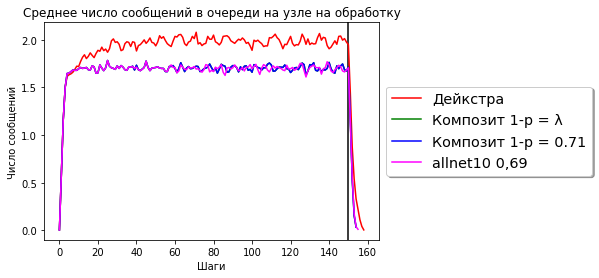

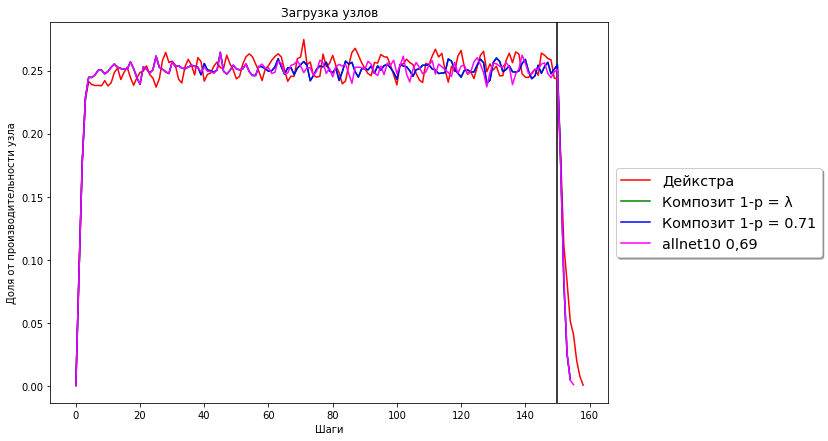

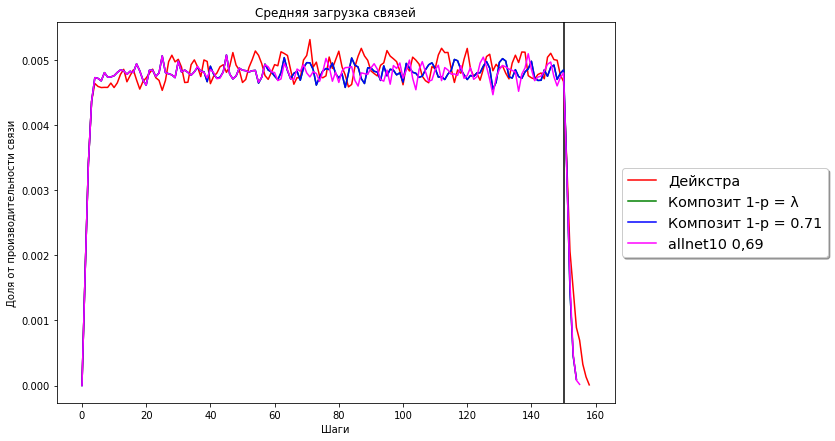

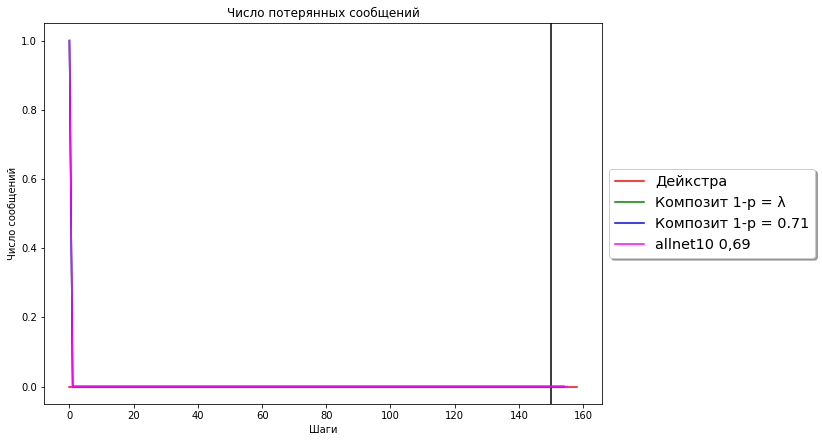

Доставлено 15001 Потеряно 0.0000% -Дейкстра
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = λ
Доставлено 15000 Потеряно 0.0067% -Композит 1-p = 0.71
Доставлено 15000 Потеряно 0.0067% -allnet10 0,69


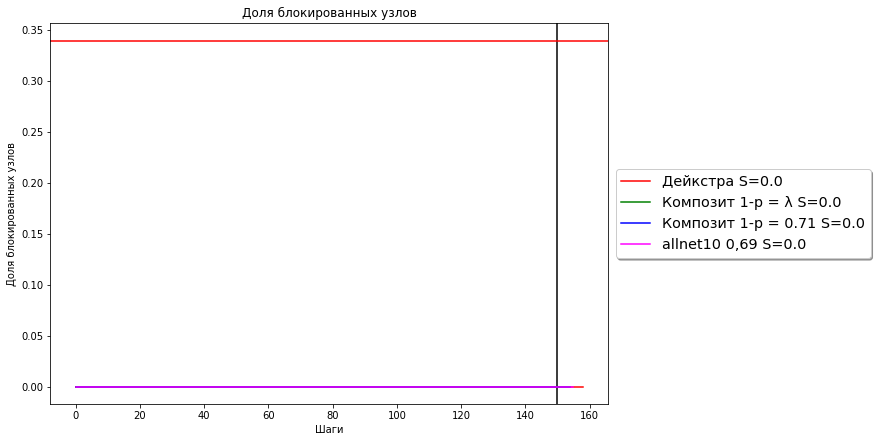

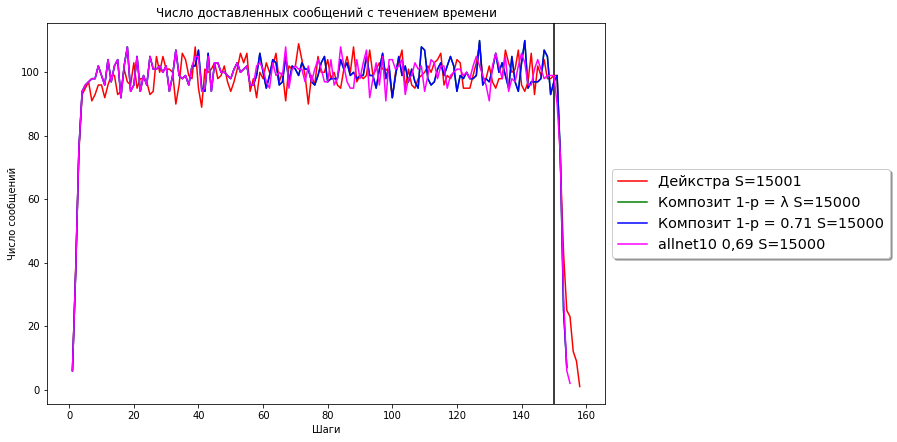

In [2]:
log_tags = [
 {"tag":  "850b838a-77a5-4199-bbce-164a0cd75c21", "label": "Дейкстра", "color": "red"},
 #{"tag":  "66872dd3-aad2-4a47-ad59-4de52ed29940", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "25670473-0add-4173-b8ac-ca6416e8c859", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "229cbe22-9caa-4d9b-9111-98294c4a9439", "label": "Композит 1-p = 0.71", "color": "blue"},
  {"tag":  "0a8e3a50-e006-4659-81ca-c8b43b628a39", "label": "allnet10 0,69", "color": "magenta"},
]
      
quantity = 100;                             
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

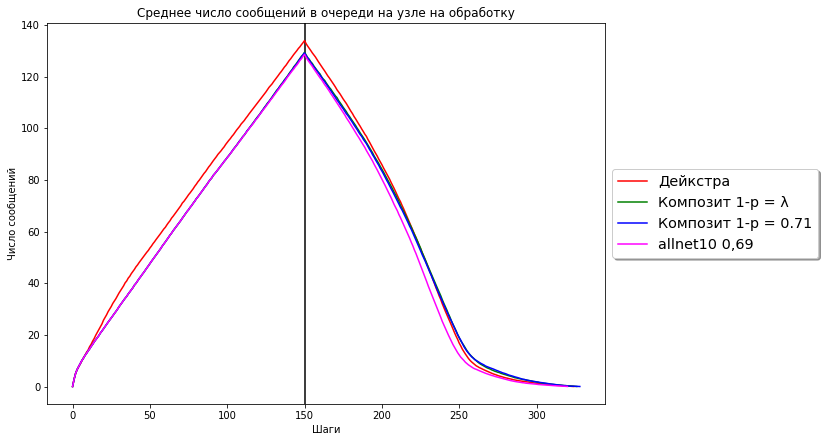

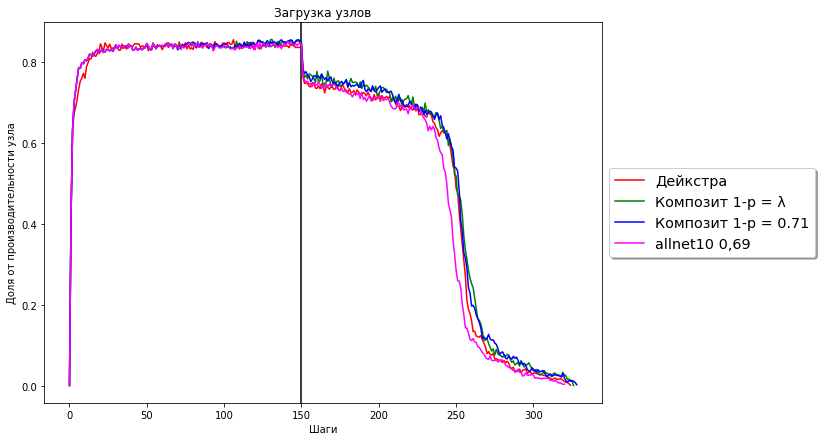

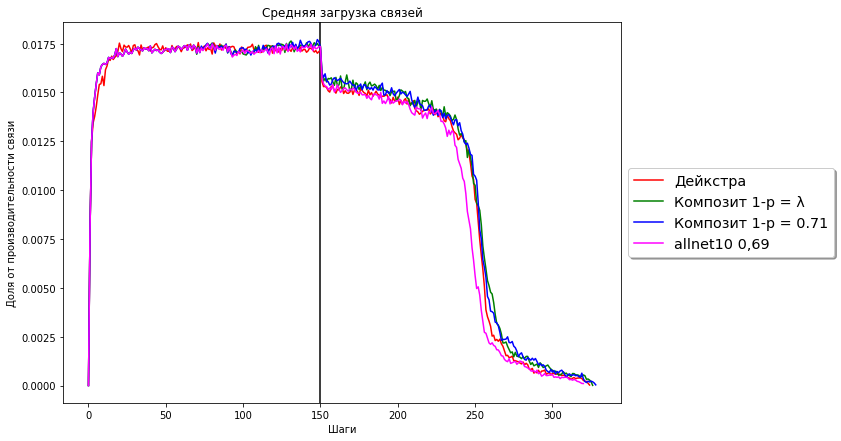

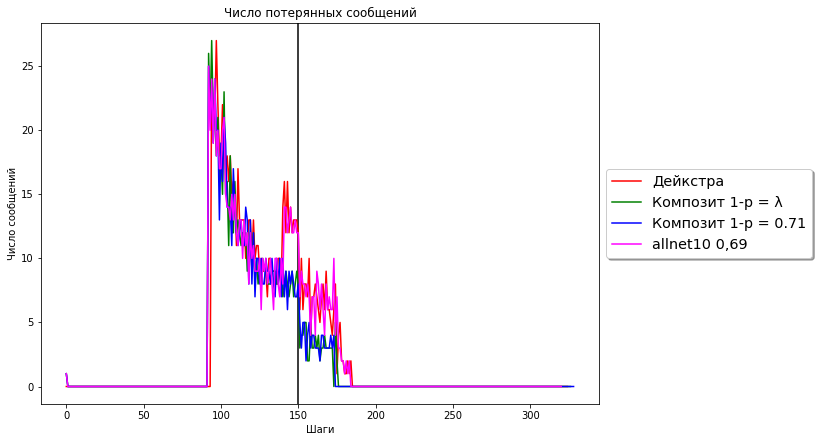

Доставлено 74043 Потеряно 1.2773% -Дейкстра
Доставлено 74212 Потеряно 1.0520% -Композит 1-p = λ
Доставлено 74211 Потеряно 1.0533% -Композит 1-p = 0.71
Доставлено 74059 Потеряно 1.2560% -allnet10 0,69


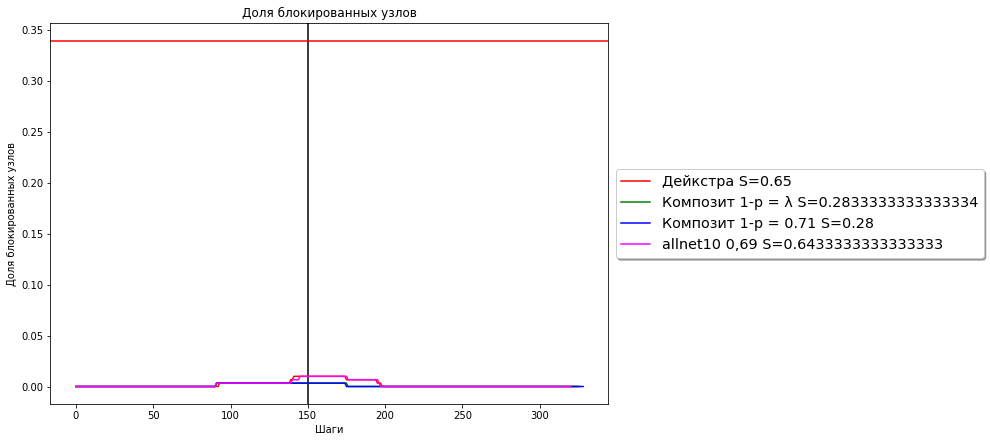

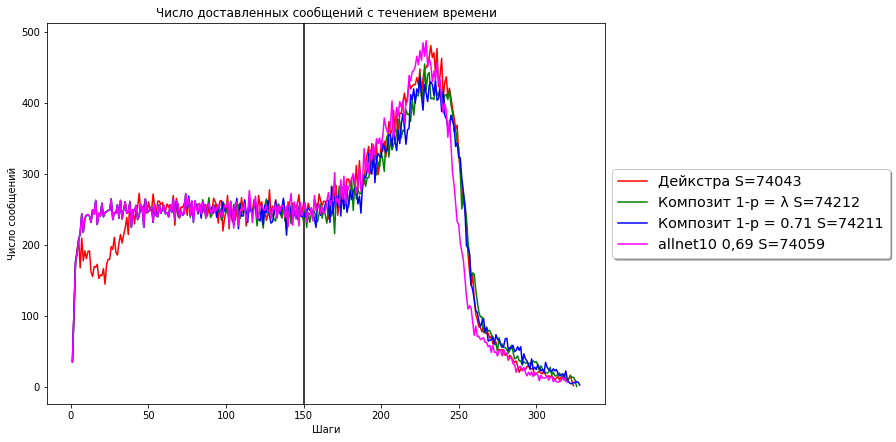

In [3]:
log_tags = [
 {"tag":  "e9cb1790-dc5e-45f4-b0f7-e7a9f5d4fe33", "label": "Дейкстра", "color": "red"},
 #{"tag":  "d4757e03-f4de-4e75-b736-821b544dfe17", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "98a25d7f-726b-46ef-9278-130f4bf19081", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "d38e0288-59ef-4e8c-96ec-75e2f0f6e2e4", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "2d7b0888-5864-4bcd-bc36-2db920cf268c", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 500; 
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

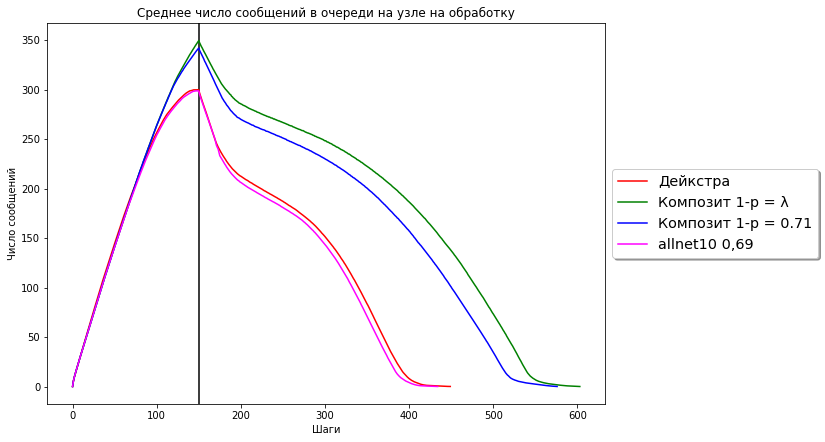

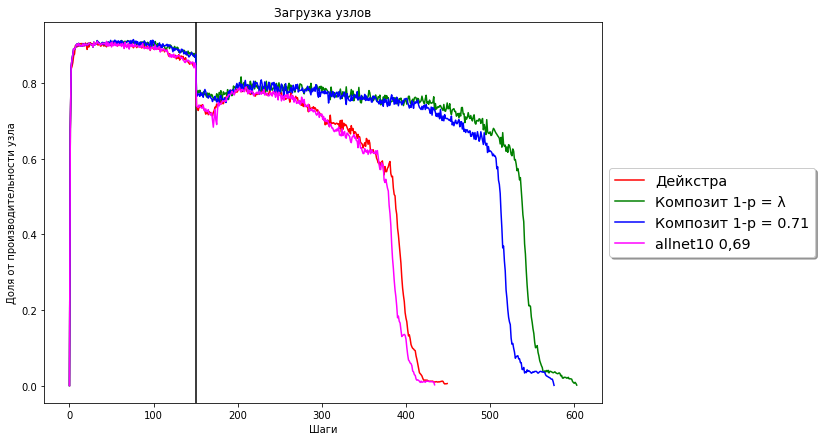

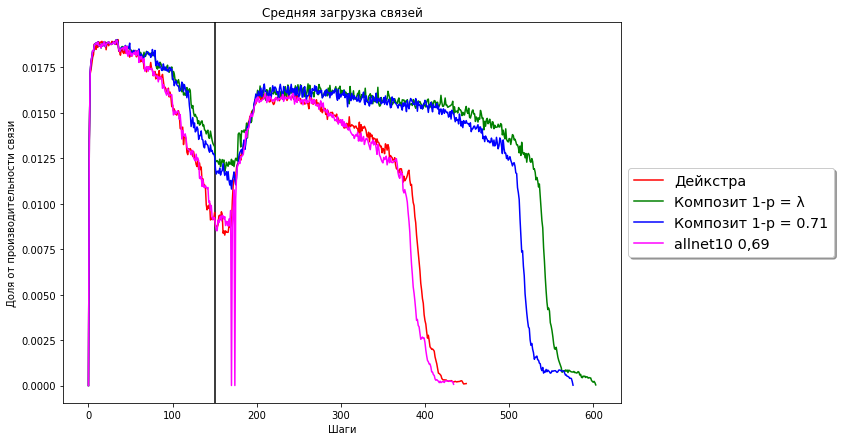

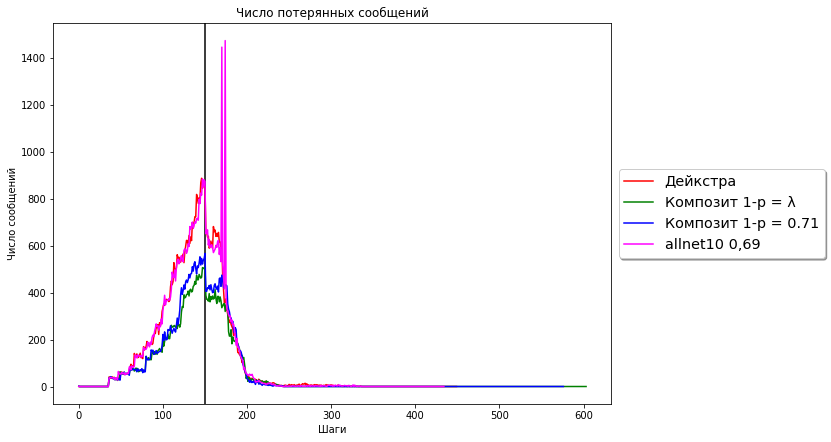

Доставлено 91582 Потеряно 38.9457% -Дейкстра
Доставлено 113034 Потеряно 24.6445% -Композит 1-p = λ
Доставлено 108983 Потеряно 27.3452% -Композит 1-p = 0.71
Доставлено 90461 Потеряно 39.6931% -allnet10 0,69


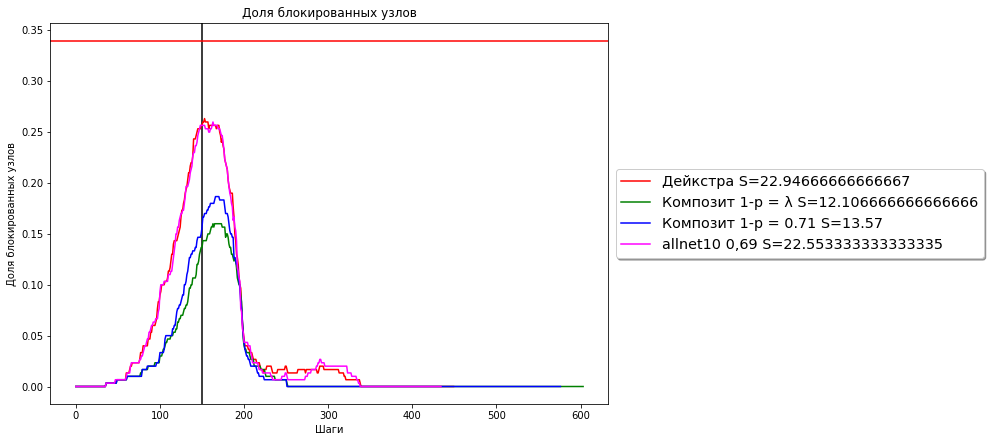

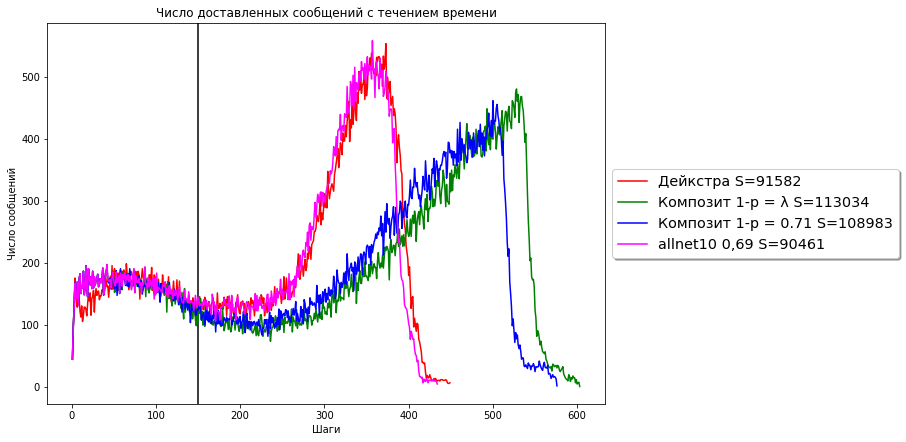

In [4]:
log_tags = [
 {"tag":  "46ac356b-736c-431c-a5f1-d729dd464a0f", "label": "Дейкстра", "color": "red"},
 #{"tag":  "8b06eba0-5d75-426c-98b4-25cdfe9a26fc", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "8f9e718c-2c06-4915-b368-95dfbe42a07f", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "8d340fb5-9894-4db5-9ccf-b43384a67b52", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "d91d9126-6e6d-46bc-8ee3-a773e1f2c465", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1000; 
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

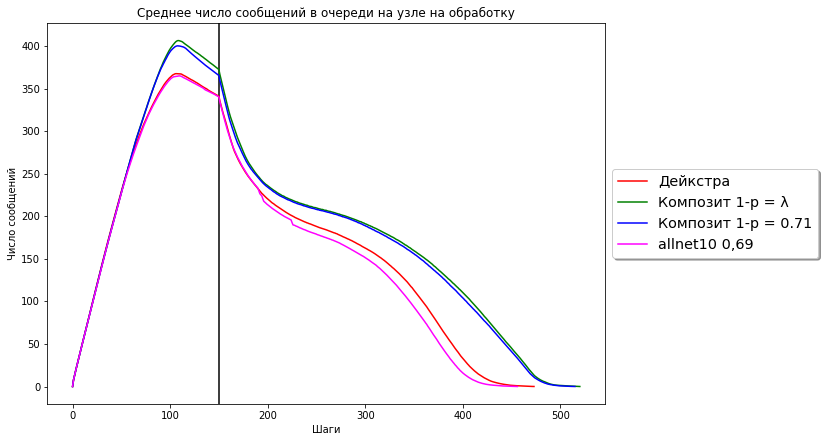

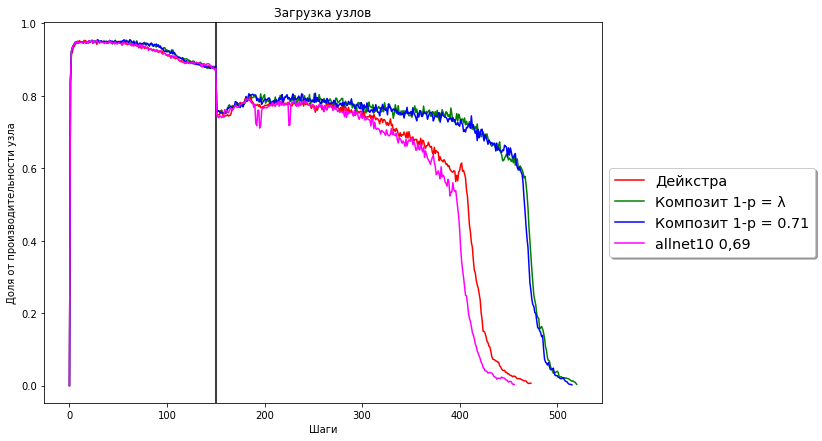

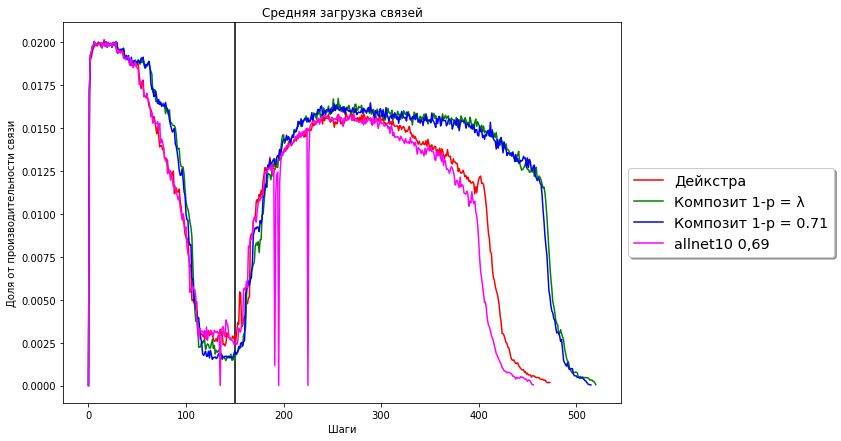

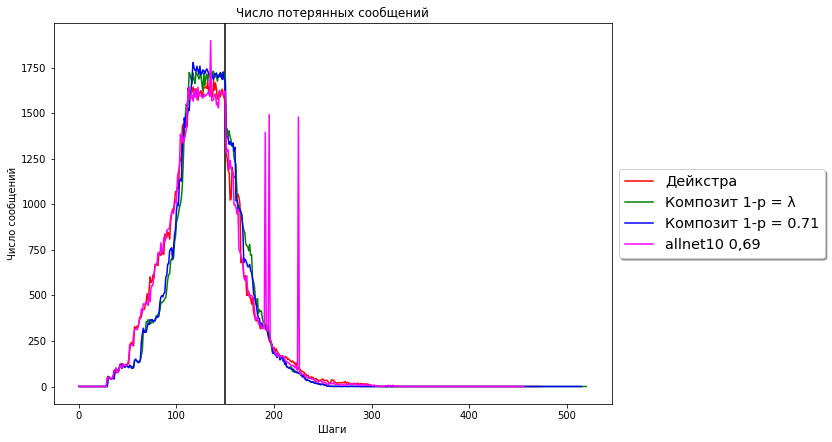

Доставлено 78748 Потеряно 65.0010% -Дейкстра
Доставлено 84112 Потеряно 62.6171% -Композит 1-p = λ
Доставлено 83928 Потеряно 62.6988% -Композит 1-p = 0.71
Доставлено 76603 Потеряно 65.9544% -allnet10 0,69


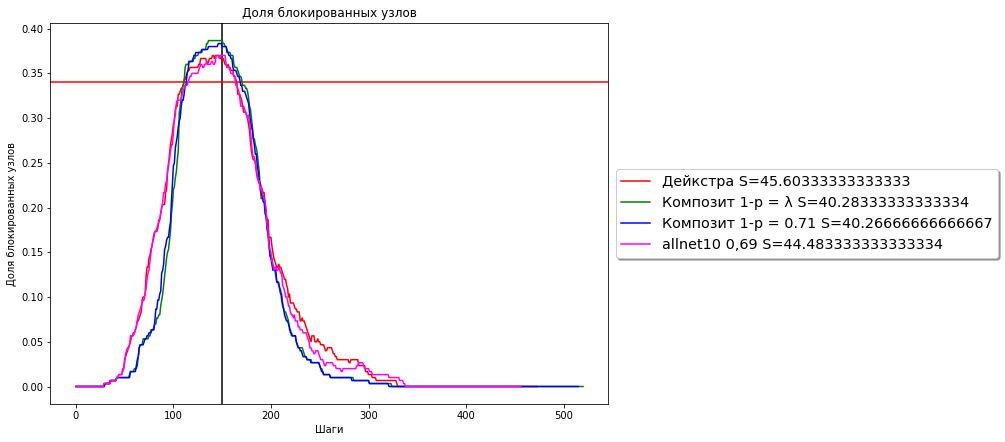

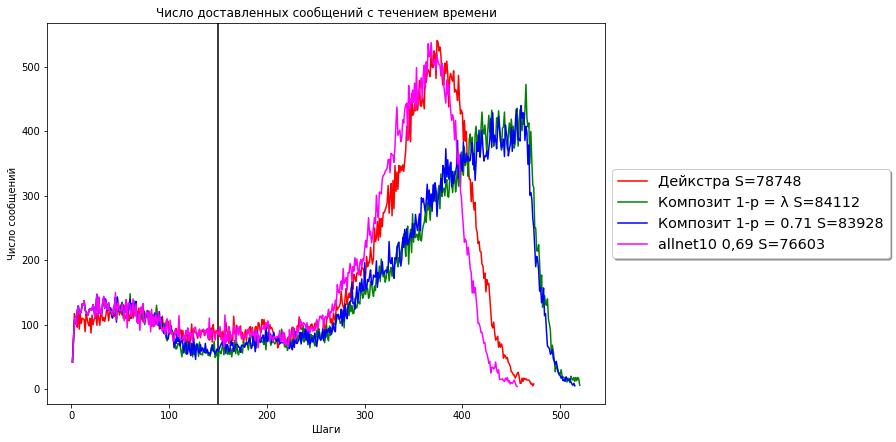

In [5]:
log_tags = [
 {"tag":  "1327951f-1e4b-4ee7-9a3d-e23092633329", "label": "Дейкстра", "color": "red"},
 #{"tag":  "e0ca3ab2-a902-4b06-96b9-db892dc1bc99", "label": "Композит 1-p = 0.95", "color": ""},
 {"tag":  "9ce35a32-1f16-407e-87ac-02da6af36bba", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "290dfd94-aa6f-4f4c-bca2-f66bb61d30ed", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "dfde7cb2-852e-4f2c-94a9-c09eaa3a3369", "label": "allnet10 0,69", "color": "magenta"},
]
quantity = 1500; 
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 44637 Потеряно 0.8089% -Дейкстра
Доставлено 44615 Потеряно 0.8578% -Композит 1-p = λ
Доставлено 44615 Потеряно 0.8578% -Композит 1-p = 0.71
Доставлено 44615 Потеряно 0.8578% -allnet10 0,69


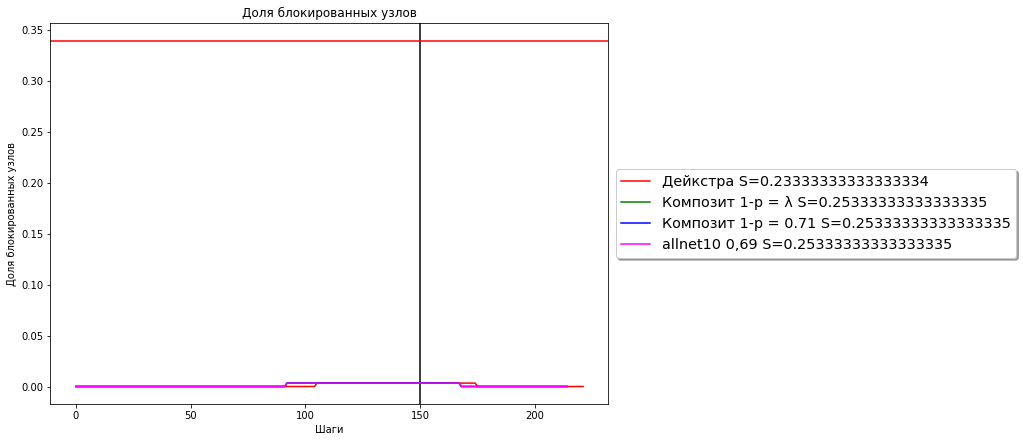

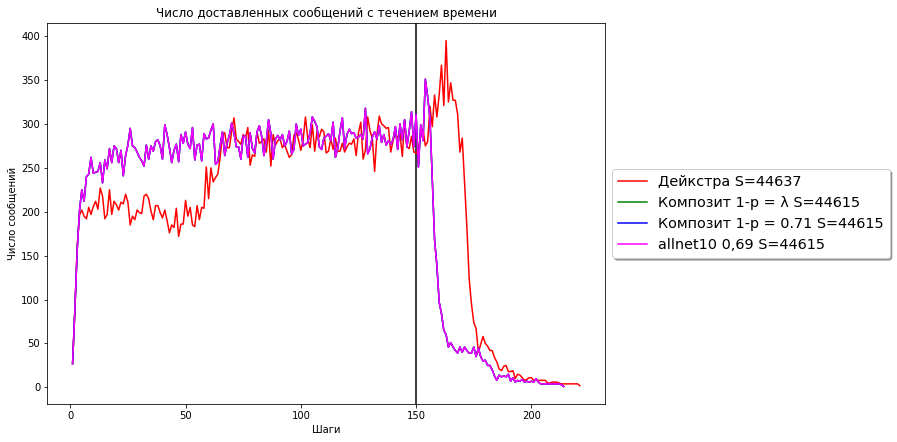

Доставлено 92567 Потеряно 11.8418% -Дейкстра
Доставлено 96770 Потеряно 7.8390% -Композит 1-p = λ
Доставлено 96581 Потеряно 8.0190% -Композит 1-p = 0.71
Доставлено 92802 Потеряно 11.6180% -allnet10 0,69


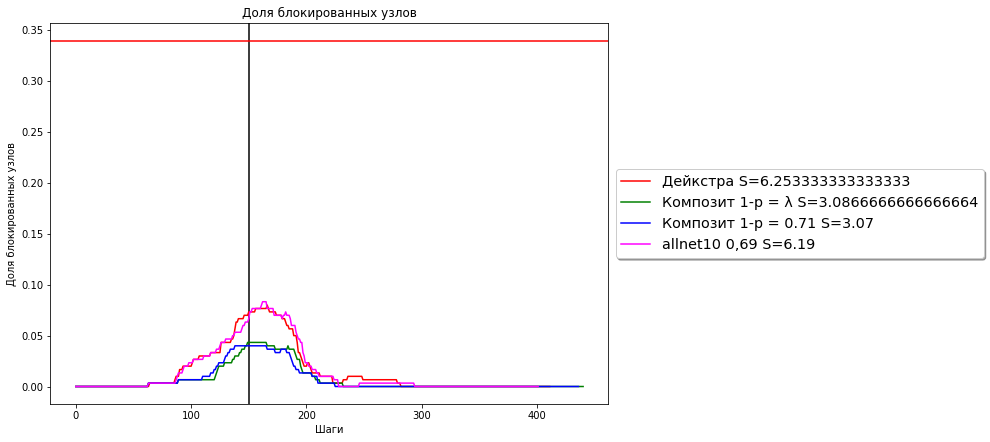

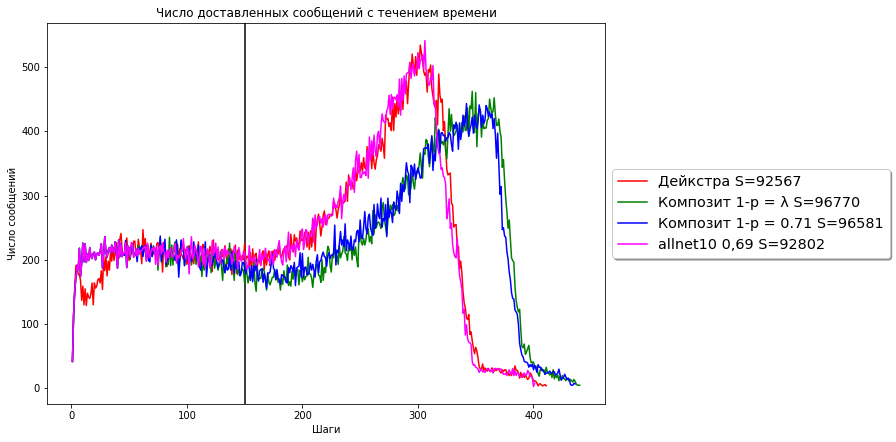

Доставлено 91040 Потеряно 32.5635% -Дейкстра
Доставлено 110864 Потеряно 17.8791% -Композит 1-p = λ
Доставлено 108490 Потеряно 19.6376% -Композит 1-p = 0.71
Доставлено 90149 Потеряно 33.2235% -allnet10 0,69


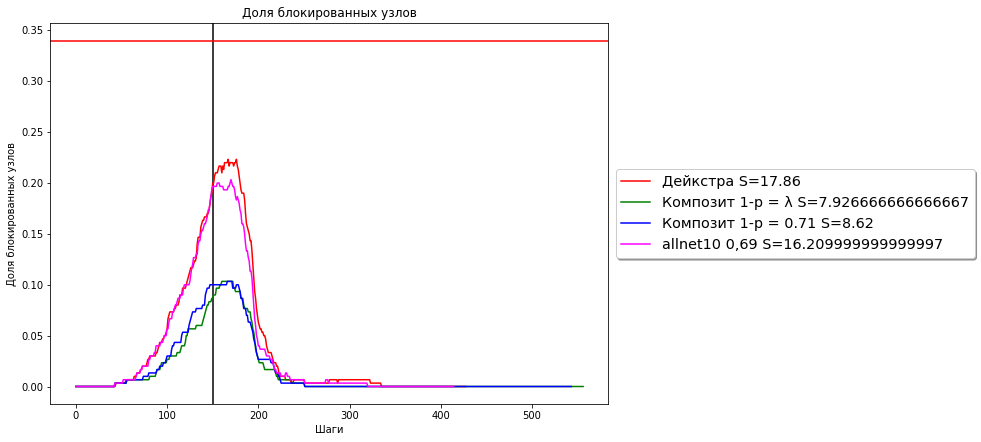

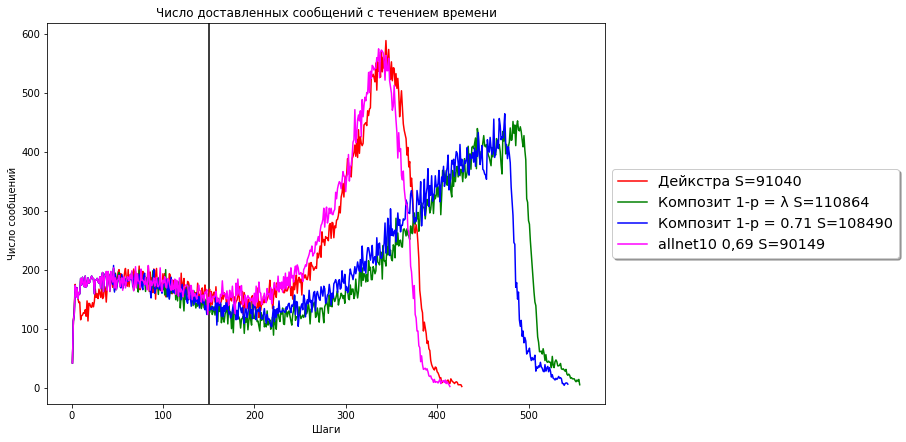

Доставлено 87535 Потеряно 51.3697% -Дейкстра
Доставлено 94624 Потеряно 47.4314% -Композит 1-p = λ
Доставлено 90733 Потеряно 49.5931% -Композит 1-p = 0.71
Доставлено 85388 Потеряно 52.5625% -allnet10 0,69


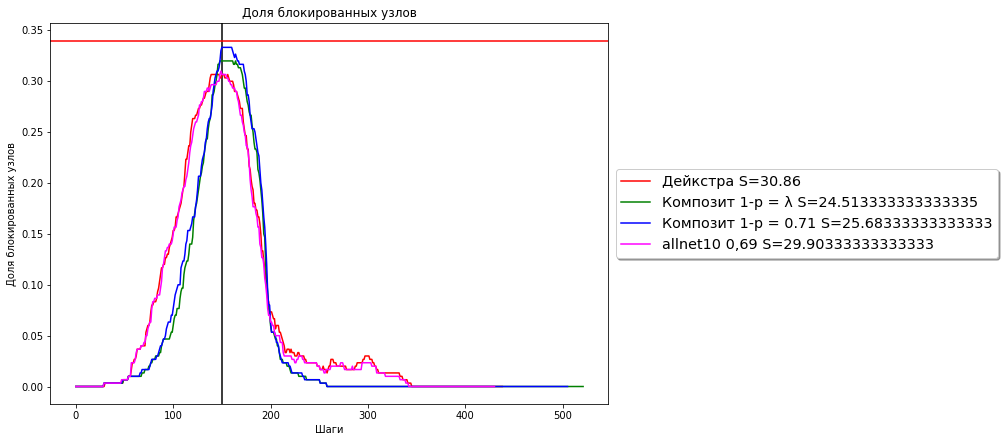

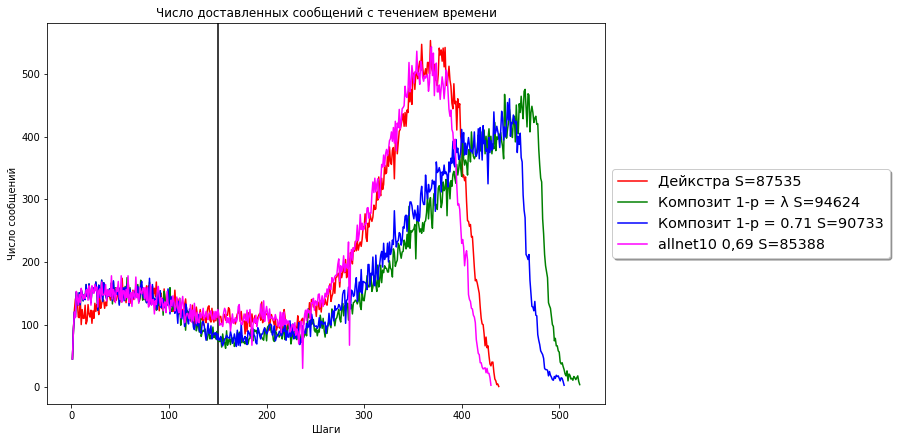

In [6]:
quantity = 300;  
log_tags = [
 {"tag":  "22144a40-339d-4deb-82fd-616b71a29d08", "label": "Дейкстра", "color": "red"},
 {"tag":  "497f6412-60e4-4b70-818d-07eeebcc9569", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "6e5151d4-72f1-4057-91d2-9f7c5a215ee7", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "8a877a19-ed3c-4856-a342-3e1f588a4e48", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 700;  
log_tags = [
 {"tag":  "1c02e8ed-64e6-400e-a34a-06564785ade4", "label": "Дейкстра", "color": "red"},
 {"tag":  "14cec6f9-99cb-41c4-a413-69229f95748d", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "5e8412ea-5ba1-4c75-aa5e-fce1d17d7ff0", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "f1c32260-e8e3-4c21-adae-027d74c8525a", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 900;  
log_tags = [
 {"tag":  "68b9ec47-0e03-4c4e-b956-faa2009598d4", "label": "Дейкстра", "color": "red"},
 {"tag":  "1338f912-c2a3-4517-a780-54a0000d97ca", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "1a3ac4c8-c1b0-45ee-8fb3-70a528a27d6e", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "7d9896e0-a129-4cba-aba0-142b70e6bde1", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

quantity = 1200;  
log_tags = [
 {"tag":  "5c72d973-0364-4c4e-bb87-db4693b7cbe4", "label": "Дейкстра", "color": "red"},
 {"tag":  "905045ee-8be7-426c-8e11-4cdf81b2c85a", "label": "Композит 1-p = λ", "color": "green"},
 {"tag":  "7cebff7e-861e-4c2d-bd6b-b6af405fa540", "label": "Композит 1-p = 0.71", "color": "blue"},
    {"tag":  "63b5430d-f886-4d24-9549-811c31685e42", "label": "allnet10 0,69", "color": "magenta"},
]
showStatBlocked();  
showStatMessage();

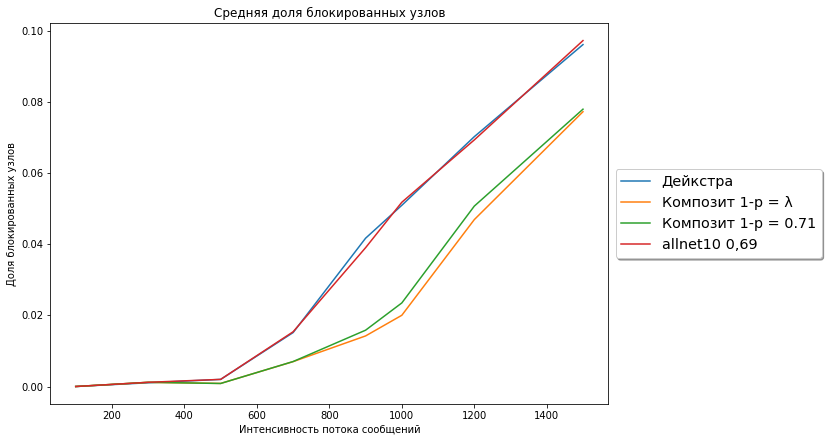

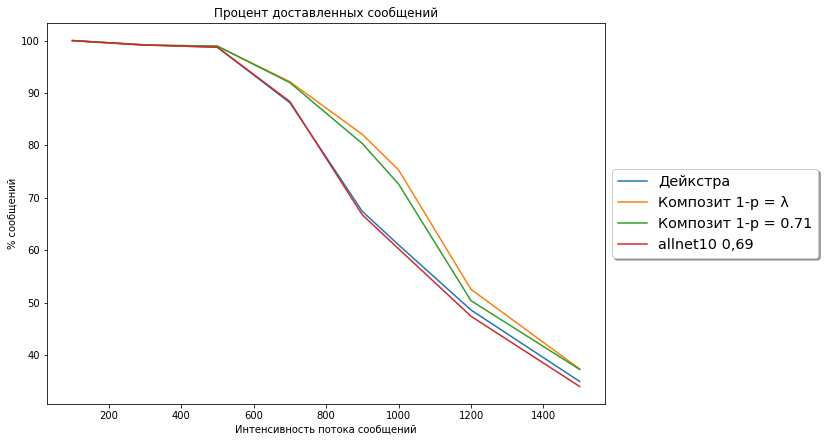

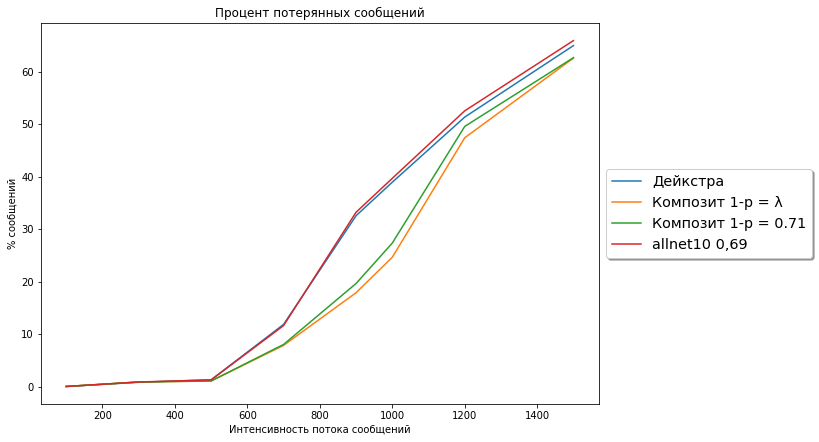

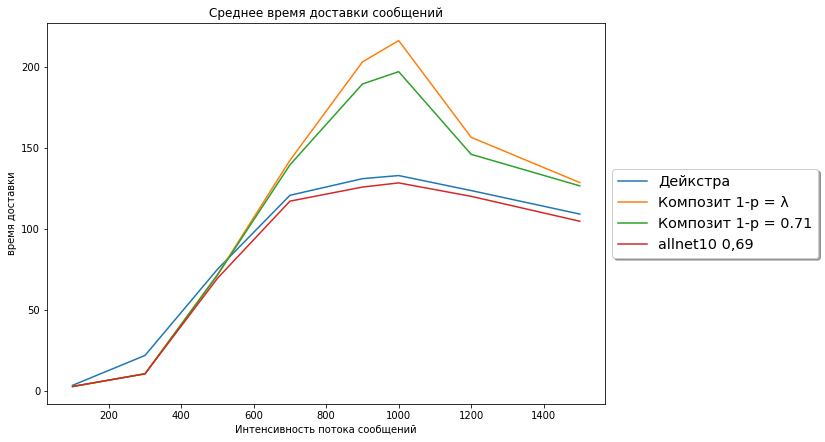

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()


In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())

Дейкстра               0.034682
Композит 1-p = λ       0.020950
Композит 1-p = 0.71    0.022152
allnet10 0,69          0.034526

Дейкстра               25.225993
Композит 1-p = λ       20.290934
Композит 1-p = 0.71    21.151424
allnet10 0,69          25.646472

Дейкстра                89.801379
Композит 1-p = λ       116.472845
Композит 1-p = 0.71    110.445663
allnet10 0,69           84.947231
